<a href="https://colab.research.google.com/github/ana-santos-ig/Diff-in-Diff-Case-Study/blob/main/Diff_in_Diff_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.Contexto do Case

##0.1 Objetivo da análise

Avaliar o impacto causal de um desconto de 15% no desempenho de class packs.

##0.2 Estrutura do Experimento



*  Grupo Teste vs Grupo Controle
*   Período Pré vs Pós
*   Métricas de funil: Views → Purchases → Conversion

#1.Carregamento e entendimento inicial dos dados

In [ ]:
#https://github.com/xbeat/Machine-Learning/blob/main/Difference-in-Differences%20(DiD)%20Analysis%20in%20Python.md

##1.1 Importação das bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, levene, mannwhitneyu, fisher_exact
from statsmodels.stats.proportion import proportions_ztest



##1.2 Carregamento do dataset

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Organizado/3.Empreenderismo/Portfolio/case - mindbody/mindbody.xlsx", sheet_name='Raw Data')

##1.3 Dicionário de dados

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Company ID                  400 non-null    int64 
 1   Period                      400 non-null    object
 2   Test Cohort                 400 non-null    object
 3   Pack Views                  400 non-null    int64 
 4   Purchases                   400 non-null    int64 
 5   Market_Standard_Pack_Price  400 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 18.9+ KB


Dicionário


*Company ID*: Unique ID corresponding to a studio/company\
*Period*: If data corresponds to pre-test or post-test\
*Test Cohort*: Control - no discount; Test - 15% discount\
*Pack Views*: Count of Views to the pack purchase page\
*Purchases*: Count of Purchases made during period\
*Market Standard Pack Price* : Cost of a pack, pre-discount



#2.Checagens de qualidade e integridade do experimento

##2.1 Verificação dos nulos

In [ ]:
df.isnull().count()

,0
Company ID,400
Period,400
Test Cohort,400
Pack Views,400
Purchases,400
Market_Standard_Pack_Price,400


Sem valores nulos

##2.2 Verificação de registros duplicados

In [ ]:
df_duplicados = df[df.duplicated(keep=False)]

In [ ]:
df_duplicados

,Company ID,Period,Test Cohort,Pack Views,Purchases,Market_Standard_Pack_Price


Sem valores duplicados

##2.3 Cada empresa possui observação em Pre e Post?

In [ ]:
df.groupby("Company ID")["Period"].nunique().value_counts()

,count
Period,
2,200


Todas as empresas possuem Pre e Post

##2.4 Verificação de vazamento de tratamento

Uma mesma empresa não deve ter mudado de grupo de preço entre o pre e post pois anula a "causalidade"

In [ ]:
df.groupby("Company ID")["Test Cohort"].nunique().value_counts()

,count
Test Cohort,
1,199
2,1


In [ ]:
df.groupby("Company ID")["Test Cohort"].nunique().sort_values(ascending=False).head()

,Test Cohort
Company ID,
101,2
1,1
3,1
2,1
5,1


##2.5 Exclusão de observações inválidas

A empresa company id não será considerada na análise.

In [ ]:
df_clean = df[df["Company ID"] != 101]

1 empresa precisou ser excluída da análise

##2.6 Preço do pack é fixo por empresa?

In [ ]:
df_clean.groupby("Company ID")["Market_Standard_Pack_Price"].nunique().value_counts()

,count
Market_Standard_Pack_Price,
1,199


Os preços por empresa não mudaram

##2.7 Sanity check do funil (Views ≥ Purchases)

In [ ]:
(df_clean["Pack Views"] > df_clean["Purchases"]).mean()

np.float64(1.0)

A quantidade de views foi maior do que a quantidade de purchases

#3.Construção de métricas derivadas

##3.1 Criação da taxa de conversão

In [ ]:
df_clean["Conversion"] = df_clean["Purchases"]/df_clean["Pack Views"]

/tmp/ipython-input-2143969010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Conversion"] = df_clean["Purchases"]/df_clean["Pack Views"]


#4.Análise exploratória (EDA)

In [ ]:
METRICS = ["Pack Views", "Purchases", "Conversion"]

##4.1 Estatísticas descritivas gerais

In [ ]:
eda_geral = df_clean.groupby(
    ["Period", "Market_Standard_Pack_Price"]
)[METRICS].describe()

eda_geral

Pack Views                            \
                                       count         mean          std   
Period Market_Standard_Pack_Price                                        
Post   10                               22.0  1152.454545   710.078716   
       15                               70.0  4734.828571  2294.684033   
       20                               50.0  7158.820000  2758.653655   
       25                               57.0  7029.824561  2580.189951   
Pre    10                               22.0  1093.272727   632.097655   
       15                               70.0  4354.942857  2053.530194   
       20                               50.0  6619.960000  2432.076110   
       25                               57.0  6578.842105  2343.422069   

                                                                              \
                                      min      25%     50%      75%      max   
Period Market_Standard_Pack_Price                                              
Post   10                           203.0   692.50   919.5  1587.75   2862.0   
       15                           396.0  3227.50  4451.0  6543.25  10927.0   
       20                          1045.0  5696.00  7652.5  9370.25  11042.0   
       25                          1218.0  5372.00  7742.0  9025.00  11516.0   
Pre    10                           250.0   615.25   962.0  1481.50   2446.0   
       15                           388.0  2817.50  4196.5  5882.25   9106.0   
       20                          1244.0  4905.50  7401.0  8515.00   9973.0   
       25                          1485.0  4810.00  7011.0  8553.00   9868.0   

                                  Purchases              ...                  \
                                      count        mean  ...     75%     max   
Period Market_Standard_Pack_Price                        ...                   
Post   10                              22.0  474.500000  ...  745.25  1160.0   
       15                              70.0  773.114286  ...  992.00  1336.0   
       20                              50.0  551.880000  ...  695.50  1087.0   
       25                              57.0  191.543860  ...  271.00   703.0   
Pre    10                              22.0  450.136364  ...  773.25   993.0   
       15                              70.0  691.057143  ...  897.25   993.0   
       20                              50.0  502.840000  ...  646.75   842.0   
       25                              57.0  164.947368  ...  247.00   513.0   

                                  Conversion                                \
                                       count      mean       std       min   
Period Market_Standard_Pack_Price                                            
Post   10                               22.0  0.417958  0.202663  0.082998   
       15                               70.0  0.186319  0.074844  0.088588   
       20                               50.0  0.078312  0.018867  0.045324   
       25                               57.0  0.026856  0.018782  0.000608   
Pre    10                               22.0  0.409864  0.198128  0.092042   
       15                               70.0  0.183926  0.076588  0.102240   
       20                               50.0  0.075741  0.013810  0.054171   
       25                               57.0  0.024877  0.016938  0.000723   

                                                                           
                                        25%       50%       75%       max  
Period Market_Standard_Pack_Price                                          
Post   10                          0.225580  0.468714  0.558247  0.806867  
       15                          0.132027  0.165910  0.212363  0.371645  
       20                          0.065746  0.074290  0.090841  0.123774  
       25                          0.008727  0.023349  0.043540  0.063557  
Pre    10                          0.246833  0.421566  0.540099  0

##4.2 Estatísticas por período e faixa de preço

In [ ]:
eda_grupo = df_clean.groupby(
    ["Period", "Market_Standard_Pack_Price", "Test Cohort"]
)[METRICS].mean()

eda_grupo


Pack Views   Purchases  \
Period Market_Standard_Pack_Price Test Cohort                            
Post   10                         Control      1019.083333  456.083333   
                                  Test         1312.500000  496.600000   
       15                         Control      3741.483871  635.129032   
                                  Test         5524.410256  882.794872   
       20                         Control      6450.892857  481.785714   
                                  Test         8059.818182  641.090909   
       25                         Control      6326.379310  137.931034   
                                  Test         7758.392857  247.071429   
Pre    10                         Control      1045.083333  483.666667   
                                  Test         1151.100000  409.900000   
       15                         Control      3672.741935  634.516129   
                                  Test         4897.205128  736.000000   
       20                         Control      6252.107143  484.714286   
                                  Test         7088.136364  525.909091   
       25                         Control      6275.724138  135.034483   
                                  Test         6892.785714  195.928571   

                                               Conversion  
Period Market_Standard_Pack_Price Test Cohort              
Post   10                         Control        0.463443  
                                  Test           0.363376  
       15                         Control        0.195796  
                                  Test           0.178785  
       20                         Control        0.076372  
                                  Test           0.080780  
       25                         Control        0.021790  
                                  Test           0.032102  
Pre    10                         Control        0.468597  
                                  Test           0.339384  
       15                         Control        0.203272  
                                  Test           0.168548  
       20                         Control        0.076470  
                                  Test           0.074813  
       25                         Control        0.021306  
                                  Test           0.028577

**Pack Views** - a exposição ou campanha aumentou o número de visualizações de pacotes, mas também causou maior dispersão nos dados.

**Purchases** - a conversão não cresceu no mesmo ritmo das visualizações, sugerindo interesse alto, mas menos decisão de compra

**Conversão** - embora o volume de interesse tenha aumentado, a taxa de conversão permaneceu estável ou até caiu, o que pode indicar problemas de\
.Usabilidade\
.Preço percebido como alto\
.Fricções no funil de conversão

##4.3 Distribuição das empresas por faixa de preço

<Axes: title={'center': 'Distribuição de preços dos packs'}, xlabel='Preço do pack', ylabel='% de empresas'>

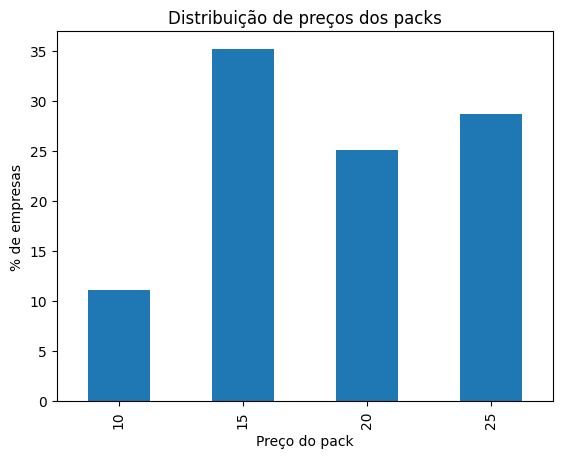

In [ ]:
price_dist = (
    df_clean["Market_Standard_Pack_Price"]
    .value_counts(normalize=True)
    .sort_index()
    * 100
)

price_dist.rename_axis("Preço do pack").plot(kind="bar", ylabel="% de empresas",
                                              title="Distribuição de preços dos packs")



A quantidade de empresas por pack de preço é bem diferente,

##4.4 Distribuição das empresas por faixa de preço

In [ ]:
price_dist = (
    df_clean["Market_Standard_Pack_Price"]
    .value_counts(normalize=True)
    .sort_index()
    * 100
)

price_dist

,proportion
Market_Standard_Pack_Price,
10,11.055276
15,35.175879
20,25.125628
25,28.643216


##4.5 Comparação da distribuição de preços entre Test e Control

In [ ]:
price_dist_cohort = (
    df_clean.groupby("Test Cohort")["Market_Standard_Pack_Price"]
    .value_counts(normalize=True)
    .sort_index()
    * 100
)

price_dist_cohort

Test Cohort  Market_Standard_Pack_Price
Control      10                            12.000000
             15                            31.000000
             20                            28.000000
             25                            29.000000
Test         10                            10.101010
             15                            39.393939
             20                            22.222222
             25                            28.282828
Name: proportion, dtype: float64

##4.6 Médias agregadas por período e grupo (visão inicial)

In [ ]:
media_geral = df_clean.groupby(
    ["Period", "Test Cohort"]
)[METRICS].mean()

media_geral

Pack Views   Purchases  Conversion
Period Test Cohort                                     
Post   Control      4923.050000  426.520000    0.144013
       Test         6294.222222  610.272727    0.134166
Pre    Control      4834.510000  429.620000    0.146836
       Test         5570.090909  503.626263    0.125386

##4.7 Médias agregadas por período e grupo (visão inicial)

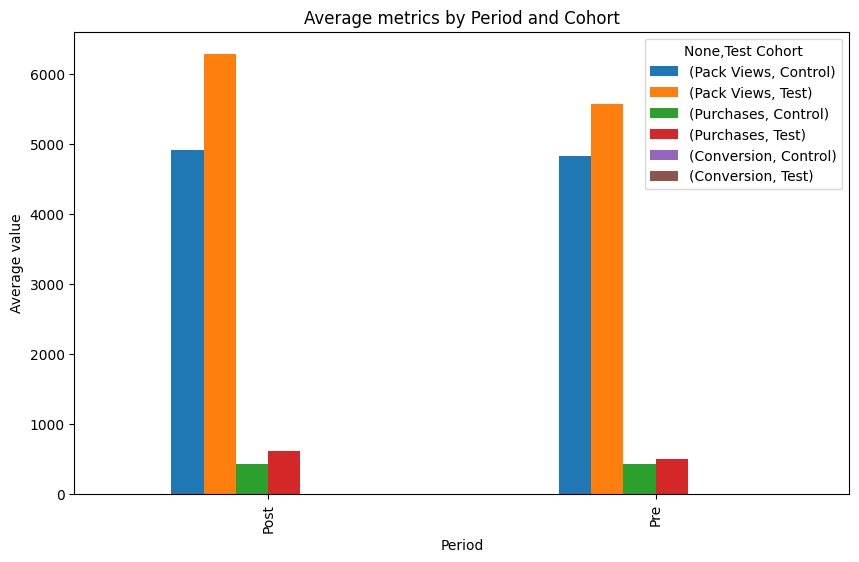

In [ ]:
media_geral.unstack("Test Cohort")[METRICS].plot(kind="bar", figsize=(10,6))
plt.title("Average metrics by Period and Cohort")
plt.ylabel("Average value")
plt.show()


Objetivo do pré-teste: verificar se Controle e Teste eram comparáveis antes da intervenção (desconto).

#5.Validação de comparabilidade no pré-período (Baseline)

Objetivo: verificar se Teste e Controle eram comparáveis antes do desconto.

##5.1 Baseline agregado — Pack Views

###5.1.1 Seleção dos dados

In [ ]:
control_views = df_clean[
    (df_clean["Test Cohort"] == "Control") &
    (df_clean["Period"] == "Pre")
]["Pack Views"]

test_views = df_clean[
    (df_clean["Test Cohort"] == "Test") &
    (df_clean["Period"] == "Pre")
]["Pack Views"]


###5.1.1 Teste de homogeneidade de variância (Levene)

In [ ]:
stat_levene, p_levene = levene(test_views, control_views)

print(f"Levene test (variances): statistic = {stat_levene:.4f}, p-value = {p_levene:.4f}")


Levene test (variances): statistic = 4.6042, p-value = 0.0331


###5.1.2 Teste de diferença de médias (t-test)

In [ ]:
equal_var = p_levene >= 0.05

t_stat, p_val = ttest_ind(test_views, control_views, equal_var=equal_var)

print(f"t-test (means): statistic = {t_stat:.4f}, p-value = {p_val:.4f}")




t-test (means): statistic = 1.8816, p-value = 0.0614


##5.2 Baseline agregado — Purchases

###5.2.1 Seleção dos dados

In [ ]:
control_purchases = df_clean[
    (df_clean["Test Cohort"] == "Control") &
    (df_clean["Period"] == "Pre")
]["Purchases"]

test_purchases = df_clean[
    (df_clean["Test Cohort"] == "Test") &
    (df_clean["Period"] == "Pre")
]["Purchases"]



###5.2.2 Teste de variância

In [ ]:
stat_levene, p_levene = levene(test_purchases, control_purchases)

print(f"Levene test (variances): statistic = {stat_levene:.4f}, p-value = {p_levene:.4f}")


Levene test (variances): statistic = 0.1400, p-value = 0.7087


###5.2.3 Teste de médias

In [ ]:
equal_var = p_levene >= 0.05

t_stat, p_val = ttest_ind(test_purchases, control_purchases, equal_var=equal_var)

print(f"t-test (means): statistic = {t_stat:.4f}, p-value = {p_val:.4f}")


t-test (means): statistic = 1.7474, p-value = 0.0821


##5.3 Baseline agregado — Conversion

##5.3.1 Seleção dos dados

In [ ]:
control_conv = df_clean[
    (df_clean["Test Cohort"] == "Control") &
    (df_clean["Period"] == "Pre")
]["Conversion"]

test_conv = df_clean[
    (df_clean["Test Cohort"] == "Test") &
    (df_clean["Period"] == "Pre")
]["Conversion"]


##5.3.2 Teste de proporções

In [ ]:
success_test = test_conv.sum()
n_test = test_conv.count()

success_control = control_conv.sum()
n_control = control_conv.count()

stat, p_val = proportions_ztest(
    [success_test, success_control],
    [n_test, n_control]
)

print(f"Z-test (proportions): statistic = {stat:.4f}, p-value = {p_val:.4f}")


Z-test (proportions): statistic = -0.4411, p-value = 0.6591


#6.Baseline por faixa de preço

Verificar se a comparabilidade se mantém dentro de cada segmento.

In [ ]:

df_pre =df_clean[df_clean["Period"] == "Pre"]

n_empresas = (
    df_pre.groupby(["Market_Standard_Pack_Price", "Test Cohort"])["Company ID"]
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
)

n_empresas.columns.name = None

print(n_empresas)


   Market_Standard_Pack_Price  Control  Test
0                          10       12    10
1                          15       31    39
2                          20       28    22
3                          25       29    28


##6.1 Faixa de preço R$10

###6.1.1  Pack Views — Teste estatístico

In [ ]:
Control_views_10 = df_clean[(df_clean["Test Cohort"] == "Control") & (df_clean["Period"] == "Pre" )& (df_clean["Market_Standard_Pack_Price"] == 10 )]["Pack Views"]
Test_views_10 = df_clean[(df_clean["Test Cohort"] == "Test")& (df_clean["Period"] == "Pre")& (df_clean["Market_Standard_Pack_Price"] == 10 )]["Pack Views"]

In [ ]:
from scipy.stats import mannwhitneyu


stat, p_valor = mannwhitneyu(Control_views_10 , Test_views_10 , alternative='two-sided')

print(f"Mann-Whitney U: estatística = {stat:.4f}, p-valor = {p_valor:.4f}")
if p_valor < 0.05:
    print("Diferença significativa entre os grupos!")
else:
    print("Sem diferença significativa.")


Mann-Whitney U: estatística = 54.0000, p-valor = 0.7169
Sem diferença significativa.


###6.1.2 Purchases — Teste estatístico

In [ ]:
Control_purchases_10 = df_clean[(df_clean["Test Cohort"] == "Control") & (df_clean["Period"] == "Pre" )& (df_clean["Market_Standard_Pack_Price"] == 10 )]["Purchases"]
Test_purchases_10 = df_clean[(df_clean["Test Cohort"] == "Test")& (df_clean["Period"] == "Pre")& (df_clean["Market_Standard_Pack_Price"] == 10 )]["Purchases"]

In [ ]:
from scipy.stats import mannwhitneyu


stat, p_valor = mannwhitneyu(Control_purchases_10, Test_purchases_10  , alternative='two-sided')

print(f"Mann-Whitney U: estatística = {stat:.4f}, p-valor = {p_valor:.4f}")
if p_valor < 0.05:
    print("Diferença significativa entre os grupos!")
else:
    print("Sem diferença significativa.")

Mann-Whitney U: estatística = 69.0000, p-valor = 0.5752
Sem diferença significativa.


###6.1.3 Conversion — Teste estatístico

In [ ]:
Control_Conversion_10 = df_clean[(df_clean["Test Cohort"] == "Control") & (df_clean["Period"] == "Pre" )& (df_clean["Market_Standard_Pack_Price"] == 10 )]["Conversion"]
Test_Conversion_10 = df_clean[(df_clean["Test Cohort"] == "Test")& (df_clean["Period"] == "Pre")& (df_clean["Market_Standard_Pack_Price"] == 10 )]["Conversion"]

In [ ]:
from scipy.stats import fisher_exact

# Soma total de conversões
compras_t = Test_Conversion_10.sum()
views_t = Test_Conversion_10.count()  # total de empresas
nao_compras_t = views_t - compras_t

compras_c = Control_Conversion_10.sum()
views_c = Control_Conversion_10.count()
nao_compras_c = views_c - compras_c

# Matriz 2x2
tabela = [[compras_t, nao_compras_t],
          [compras_c, nao_compras_c]]

# Executa o teste
_, p_valor = fisher_exact(tabela)

print(f"Conversão — Fisher’s Exact Test: p-valor = {p_valor:.4f}")
if p_valor < 0.05:
    print("Diferença significativa na conversão!")
else:
    print("Sem diferença significativa na conversão.")


Conversão — Fisher’s Exact Test: p-valor = 0.6699
Sem diferença significativa na conversão.


##6.2 Faixa de preço R$15

###6.2.1  Pack Views — Teste estatístico

In [ ]:
Control_views_15 = df_clean[(df_clean["Test Cohort"] == "Control") &
                            (df_clean["Period"] == "Pre") &
                            (df_clean["Market_Standard_Pack_Price"] == 15)]["Pack Views"]

Test_views_15 = df_clean[(df_clean["Test Cohort"] == "Test") &
                         (df_clean["Period"] == "Pre") &
                         (df_clean["Market_Standard_Pack_Price"] == 15)]["Pack Views"]


In [ ]:
stat_levene, p_levene = levene(Control_views_15, Test_views_15)
print(f"Levene - p = {p_levene:.4f}")


if p_levene >= 0.05:
    stat, p_valor = ttest_ind(Control_views_15, Test_views_15, equal_var=True)
    print("Usando t-test padrão")
else:
    stat, p_valor = ttest_ind(Control_views_15, Test_views_15, equal_var=False)
    print("Usando Welch’s t-test")

print(f"Views: estatística = {stat:.4f}, p = {p_valor:.4f}")

Levene - p = 0.8387
Usando t-test padrão
Views: estatística = -2.5774, p = 0.0121


###6.2.2 Purchases — Teste estatístico

In [ ]:
Control_purchases_15 = df_clean[(df_clean["Test Cohort"] == "Control") &
                                (df_clean["Period"] == "Pre") &
                                (df_clean["Market_Standard_Pack_Price"] == 15)]["Purchases"]

Test_purchases_15 = df_clean[(df_clean["Test Cohort"] == "Test") &
                             (df_clean["Period"] == "Pre") &
                             (df_clean["Market_Standard_Pack_Price"] == 15)]["Purchases"]

stat_levene, p_levene = levene(Control_purchases_15, Test_purchases_15)
print(f"Levene - p = {p_levene:.4f}")


if p_levene >= 0.05:
    stat, p_valor = ttest_ind(Control_purchases_15, Test_purchases_15, equal_var=True)
    print("Usando t-test padrão")
else:
    stat, p_valor = ttest_ind(Control_purchases_15, Test_purchases_15, equal_var=False)
    print("Usando Welch’s t-test")

print(f"Purchases: estatística = {stat:.4f}, p = {p_valor:.4f}")

Levene - p = 0.0466
Usando Welch’s t-test
Purchases: estatística = -1.7857, p = 0.0798


###6.2.3 Conversion — Teste estatístico

In [ ]:
Control_Conversion_15 = df_clean[(df_clean["Test Cohort"] == "Control") & (df_clean["Period"] == "Pre" )& (df_clean["Market_Standard_Pack_Price"] == 15 )]["Conversion"]
Test_Conversion_15 = df_clean[(df_clean["Test Cohort"] == "Test")& (df_clean["Period"] == "Pre")& (df_clean["Market_Standard_Pack_Price"] == 15 )]["Conversion"]

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

compras_t = Test_Conversion_15.sum()
n_t = Test_Conversion_15.count()

compras_c = Control_Conversion_15.sum()
n_c = Control_Conversion_15.count()

stat, p_valor = proportions_ztest([compras_t, compras_c], [n_t, n_c])

print(f"Conversão - Z-test: estatística = {stat:.4f}, p = {p_valor:.4f}")
if p_valor < 0.05:
    print("Diferença significativa na conversão!")
else:
    print("Sem diferença significativa.")


Conversão - Z-test: estatística = -0.3725, p = 0.7095
Sem diferença significativa.


##6.3 Faixa de preço R$20

###6.3.1  Pack Views — Teste estatístico

In [ ]:
from scipy.stats import ttest_ind

# Dados de views
Control_views_20 = df_clean[(df_clean["Test Cohort"] == "Control") &
                            (df_clean["Period"] == "Pre") &
                            (df_clean["Market_Standard_Pack_Price"] == 20)]["Pack Views"]

Test_views_20 = df_clean[(df_clean["Test Cohort"] == "Test") &
                         (df_clean["Period"] == "Pre") &
                         (df_clean["Market_Standard_Pack_Price"] == 20)]["Pack Views"]

# Welch’s t-test (equal_var=False)
stat, p_valor = ttest_ind(Control_views_20, Test_views_20, equal_var=False)

print(f"Views - Welch’s t-test: estatística = {stat:.4f}, p = {p_valor:.4f}")
if p_valor < 0.05:
    print("Diferença significativa em views!")
else:
    print("Sem diferença significativa em views.")

Views - Welch’s t-test: estatística = -1.2496, p = 0.2175
Sem diferença significativa em views.


###6.3.2 Purchases — Teste estatístico

In [ ]:
# Dados de purchases
Control_purchases_20 = df_clean[(df_clean["Test Cohort"] == "Control") &
                                (df_clean["Period"] == "Pre") &
                                (df_clean["Market_Standard_Pack_Price"] == 20)]["Purchases"]

Test_purchases_20 = df_clean[(df_clean["Test Cohort"] == "Test") &
                             (df_clean["Period"] == "Pre") &
                             (df_clean["Market_Standard_Pack_Price"] == 20)]["Purchases"]

# Welch’s t-test
stat, p_valor = ttest_ind(Control_purchases_20, Test_purchases_20, equal_var=False)

print(f"Purchases - Welch’s t-test: estatística = {stat:.4f}, p = {p_valor:.4f}")
if p_valor < 0.05:
    print("Diferença significativa em purchases!")
else:
    print("Sem diferença significativa em purchases.")


Purchases - Welch’s t-test: estatística = -0.7203, p = 0.4748
Sem diferença significativa em purchases.


###6.3.3 Conversion — Teste estatístico

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Conversões e visualizações
Control_Conversion_20 = df_clean[(df_clean["Test Cohort"] == "Control") &
                                 (df_clean["Period"] == "Pre") &
                                 (df_clean["Market_Standard_Pack_Price"] == 20)]["Conversion"]

Test_Conversion_20 = df_clean[(df_clean["Test Cohort"] == "Test") &
                              (df_clean["Period"] == "Pre") &
                              (df_clean["Market_Standard_Pack_Price"] == 20)]["Conversion"]

compras_c = Control_Conversion_20.sum()
n_c = Control_Conversion_20.count()

compras_t = Test_Conversion_20.sum()
n_t = Test_Conversion_20.count()

# Z-test de proporções
stat, p_valor = proportions_ztest([compras_t, compras_c], [n_t, n_c])

print(f"Conversão - Z-test: estatística = {stat:.4f}, p = {p_valor:.4f}")
if p_valor < 0.05:
    print("Diferença significativa na conversão!")
else:
    print("Sem diferença significativa na conversão.")


Conversão - Z-test: estatística = -0.0220, p = 0.9825
Sem diferença significativa na conversão.


##6.4 Faixa de preço R$25

###6.4.1  Pack Views — Teste estatístico

In [ ]:
from scipy.stats import levene, ttest_ind

# Dados de views
Control_views_25 = df_clean[(df_clean["Test Cohort"] == "Control") &
                            (df_clean["Period"] == "Pre") &
                            (df_clean["Market_Standard_Pack_Price"] == 25)]["Pack Views"]

Test_views_25 = df_clean[(df_clean["Test Cohort"] == "Test") &
                         (df_clean["Period"] == "Pre") &
                         (df_clean["Market_Standard_Pack_Price"] == 25)]["Pack Views"]




In [ ]:
# Levene
stat_levene, p_levene = levene(Control_views_25, Test_views_25)
print(f"Levene (Views): p = {p_levene:.4f}")

# Escolhe o teste
if p_levene >= 0.05:
    stat, p_valor = ttest_ind(Control_views_25, Test_views_25, equal_var=True)
    print("Views - t-test padrão")
else:
    stat, p_valor = ttest_ind(Control_views_25, Test_views_25, equal_var=False)
    print("Views - Welch’s t-test")

print(f"Views: estatística = {stat:.4f}, p = {p_valor:.4f}")

Levene (Views): p = 0.0165
Views - Welch’s t-test
Views: estatística = -1.0003, p = 0.3220


###6.4.2 Purchases — Teste estatístico

In [ ]:
# Dados de purchases
Control_purchases_25 = df_clean[(df_clean["Test Cohort"] == "Control") &
                                (df_clean["Period"] == "Pre") &
                                (df_clean["Market_Standard_Pack_Price"] == 25)]["Purchases"]

Test_purchases_25 = df_clean[(df_clean["Test Cohort"] == "Test") &
                             (df_clean["Period"] == "Pre") &
                             (df_clean["Market_Standard_Pack_Price"] == 25)]["Purchases"]



In [ ]:
# Levene
stat_levene, p_levene = levene(Control_purchases_25, Test_purchases_25)
print(f"Levene (Purchases): p = {p_levene:.4f}")

# Escolhe o teste
if p_levene >= 0.05:
    stat, p_valor = ttest_ind(Control_purchases_25, Test_purchases_25, equal_var=True)
    print("Purchases - t-test padrão")
else:
    stat, p_valor = ttest_ind(Control_purchases_25, Test_purchases_25, equal_var=False)
    print("Purchases - Welch’s t-test")

print(f"Purchases: estatística = {stat:.4f}, p = {p_valor:.4f}")

Levene (Purchases): p = 0.2819
Purchases - t-test padrão
Purchases: estatística = -1.7501, p = 0.0857


###6.4.3 Conversion — Teste estatístico



In [ ]:
# Conversões e visualizações
Control_Conversion_25 = df_clean[(df_clean["Test Cohort"] == "Control") &
                                 (df_clean["Period"] == "Pre") &
                                 (df_clean["Market_Standard_Pack_Price"] == 25)]["Conversion"]

Test_Conversion_25 = df_clean[(df_clean["Test Cohort"] == "Test") &
                              (df_clean["Period"] == "Pre") &
                              (df_clean["Market_Standard_Pack_Price"] == 25)]["Conversion"]

In [ ]:
compras_c = Control_Conversion_25.sum()
n_c = Control_Conversion_25.count()

compras_t = Test_Conversion_25.sum()
n_t = Test_Conversion_25.count()

# Z-test de proporções
stat, p_valor = proportions_ztest([compras_t, compras_c], [n_t, n_c])

print(f"Conversão - Z-test: estatística = {stat:.4f}, p = {p_valor:.4f}")
if p_valor < 0.05:
    print("Diferença significativa na conversão!")
else:
    print("Sem diferença significativa na conversão.")

Conversão - Z-test: estatística = 0.1762, p = 0.8601
Sem diferença significativa na conversão.


##6.5 Conclusão do baseline

*Resultado geral (todos os preços juntos):*

*  Pack Views: não houve diferença significativa (Welch’s t-test, p = 0.0614).
*  Purchases: sem diferença significativa (t-test padrão, p = 0.2385
*  Conversão:  houve diferença significativa (Z-test de proporções, p = 0.0059).

*Análise por faixa de preço:*

**Preço R$10:**

*   Views: p = 0.7169 → sem diferença
*   Purchases: p = 0.5752 → sem diferença
*   Conversão: p = 0.6699 → sem diferença

**Preço R$15:**
*   Views: p = 0.0121 →  diferença significativa
*   Purchases: p = 0.0798 → sem diferença (marginal)
*   Conversão: p = 0.7095 → sem diferença

**Preço R$20:**
*   Views: p = 0.2175 → sem diferença
*   Purchases: p = 0.4748 → sem diferença
*   Conversão: p = 0.9825 → sem diferença

**Preço R$25:**
*  Views: p = 0.3220 → sem diferença
*  Purchases: p = 0.0857 → sem diferença (marginal)
*  Conversão: p = 0.8601 → sem diferença

*Conclusão:*

Os grupos eram amplamente comparáveis no pré-período.

A principal exceção foi a conversão total (agregada), que já apresentava diferença significativa.

Também houve uma diferença significativa em views para o preço R$15.

Esses achados reforçam a necessidade de usar Difference-in-Differences para controlar viés pré-existente.

#7.Evolução temporal (Pre vs Post)

##7.1 Evolução agregada das métricas

In [ ]:
evolucao_agg = df_clean.groupby(
    ["Period", "Test Cohort"]
)[METRICS].mean()

evolucao = evolucao_agg.unstack("Period")
evolucao[("Purchases", "Delta")] = (
    evolucao[("Purchases", "Post")] - evolucao[("Purchases", "Pre")]
)

evolucao[("Pack Views", "Delta")] = (
    evolucao[("Pack Views", "Post")] - evolucao[("Pack Views", "Pre")]
)

evolucao[("Conversion", "Delta")] = (
    evolucao[("Conversion", "Post")] - evolucao[("Conversion", "Pre")]
)

evolucao.loc["Diff-in-Diff", ("Purchases", "Delta")] = (
    evolucao.loc["Test", ("Purchases", "Delta")] -
    evolucao.loc["Control", ("Purchases", "Delta")]
)

evolucao.loc["Diff-in-Diff", ("Pack Views", "Delta")] = (
    evolucao.loc["Test", ("Pack Views", "Delta")] -
    evolucao.loc["Control", ("Pack Views", "Delta")]
)

evolucao.loc["Diff-in-Diff", ("Conversion", "Delta")] = (
    evolucao.loc["Test", ("Conversion", "Delta")] -
    evolucao.loc["Control", ("Conversion", "Delta")]
)

ordem_colunas = [
    ("Purchases", "Pre"), ("Purchases", "Post"), ("Purchases", "Delta"),
    ("Pack Views", "Pre"), ("Pack Views", "Post"), ("Pack Views", "Delta"),
    ("Conversion", "Pre"), ("Conversion", "Post"), ("Conversion", "Delta"),
]

evolucao_final = evolucao[ordem_colunas]
evolucao_final = evolucao_final.fillna("-")
evolucao_final

Purchases                           Pack Views               \
Period               Pre        Post       Delta          Pre         Post   
Test Cohort                                                                  
Control           429.62      426.52   -3.100000      4834.51      4923.05   
Test          503.626263  610.272727  106.646465  5570.090909  6294.222222   
Diff-in-Diff           -           -  109.746465            -            -   

                         Conversion                      
Period             Delta        Pre      Post     Delta  
Test Cohort                                              
Control        88.540000   0.146836  0.144013 -0.002823  
Test          724.131313   0.125386  0.134166  0.008779  
Diff-in-Diff  635.591313          -         -  0.011602

##7.1 Evolução agregada das métricas por faixa de preço

In [ ]:

evolucao_preco_agg = df_clean.groupby(
    ["Market_Standard_Pack_Price", "Period", "Test Cohort"]
)[METRICS].mean()


evolucao_preco = evolucao_preco_agg.unstack("Period")


evolucao_preco[("Purchases", "Delta")] = (
    evolucao_preco[("Purchases", "Post")] - evolucao_preco[("Purchases", "Pre")]
)

evolucao_preco[("Pack Views", "Delta")] = (
    evolucao_preco[("Pack Views", "Post")] - evolucao_preco[("Pack Views", "Pre")]
)

evolucao_preco[("Conversion", "Delta")] = (
    evolucao_preco[("Conversion", "Post")] - evolucao_preco[("Conversion", "Pre")]
)


test_delta = evolucao_preco.xs("Test", level="Test Cohort")
control_delta = evolucao_preco.xs("Control", level="Test Cohort")


did_preco = test_delta[[("Purchases","Delta"),("Pack Views","Delta"),("Conversion","Delta")]] - \
            control_delta[[("Purchases","Delta"),("Pack Views","Delta"),("Conversion","Delta")]]

did_preco["Test Cohort"] = "Diff-in-Diff"
did_preco = did_preco.set_index("Test Cohort", append=True)


evolucao_preco_final = pd.concat([evolucao_preco, did_preco]).sort_index()

ordem_colunas = [
    ("Purchases", "Pre"), ("Purchases", "Post"), ("Purchases", "Delta"),
    ("Pack Views", "Pre"), ("Pack Views", "Post"), ("Pack Views", "Delta"),
    ("Conversion", "Pre"), ("Conversion", "Post"), ("Conversion", "Delta"),
]

evolucao_preco_final = evolucao_preco_final[ordem_colunas]
evolucao_preco_final = evolucao_preco_final.fillna("-")

evolucao_preco_final


Purchases                          \
Period                                          Pre        Post       Delta   
Market_Standard_Pack_Price Test Cohort                                        
10                         Control       483.666667  456.083333  -27.583333   
                           Diff-in-Diff           -           -  114.283333   
                           Test               409.9       496.6   86.700000   
15                         Control       634.516129  635.129032    0.612903   
                           Diff-in-Diff           -           -  146.181969   
                           Test               736.0  882.794872  146.794872   
20                         Control       484.714286  481.785714   -2.928571   
                           Diff-in-Diff           -           -  118.110390   
                           Test          525.909091  641.090909  115.181818   
25                         Control       135.034483  137.931034    2.896552   
                           Diff-in-Diff           -           -   48.246305   
                           Test          195.928571  247.071429   51.142857   

                                          Pack Views                           \
Period                                           Pre         Post       Delta   
Market_Standard_Pack_Price Test Cohort                                          
10                         Control       1045.083333  1019.083333  -26.000000   
                           Diff-in-Diff            -            -  187.400000   
                           Test               1151.1       1312.5  161.400000   
15                         Control       3672.741935  3741.483871   68.741935   
                           Diff-in-Diff            -            -  558.463193   
                           Test          4897.205128  5524.410256  627.205128   
20                         Control       6252.107143  6450.892857  198.785714   
                           Diff-in-Diff            -            -  772.896104   
                           Test          7088.136364  8059.818182  971.681818   
25                         Control       6275.724138   6326.37931   50.655172   
                           Diff-in-Diff            -            -  814.951970   
                           Test          6892.785714  7758.392857  865.607143   

                                        Conversion                      
Period                                         Pre      Post     Delta  
Market_Standard_Pack_Price Test Cohort                                  
10                         Control        0.468597  0.463443 -0.005154  
                           Diff-in-Diff          -         -  0.029146  
                           Test           0.339384  0.363376  0.023992  
15                         Control        0.203272  0.195796 -0.007476  
                           Diff-in-Diff          -         -  0.017713  
                           Test           0.168548  0.178785  0.010237  
20                         Control         0.07647  0.076372 -0.000098  
                           Diff-in-Diff          -         -  0.006065  
                           Test           0.074813   0.08078  0.005967  
25                         Control        0.021306   0.02179  0.000484  
                           Diff-in-Diff          -         -  0.003041  
                           Test           0.028577  0.032102  0.003525

#8.Estimativa do efeito causal — Diff-in-Diff (por médias)

##8.1 Construção das variáveis indicadoras

##8.2.Pack Views

###8.2.1 Tabela 2×2

In [ ]:
pack_views_base = df_clean.groupby(
    ["Period", "Test Cohort"]
)["Pack Views"].mean()
pack_views_tab = pack_views_base.unstack("Period")

###8.2.2 Cálculo do Diff-in-Diff

In [ ]:
pack_views_tab["Delta"] = pack_views_tab["Post"] - pack_views_tab["Pre"]
pack_views_did = pack_views_tab.loc["Test", "Delta"] - pack_views_tab.loc["Control", "Delta"]


pack_views_tab.loc["Diff-in-Diff", "Pre"] = "-"
pack_views_tab.loc["Diff-in-Diff", "Post"] = "-"
pack_views_tab.loc["Diff-in-Diff", "Delta"] = pack_views_did
pack_views_tab

/tmp/ipython-input-1597806175.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pack_views_tab.loc["Diff-in-Diff", "Pre"] = "-"
/tmp/ipython-input-1597806175.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pack_views_tab.loc["Diff-in-Diff", "Post"] = "-"


Period,Post,Pre,Delta
Test Cohort,,,
Control,4923.05,4834.51,88.540000
Test,6294.222222,5570.090909,724.131313
Diff-in-Diff,-,-,635.591313


##8.3.Purchases

###8.3.1 Tabela 2×2

In [ ]:
purchases_base = df_clean.groupby(
    ["Period", "Test Cohort"]
)["Purchases"].mean()

purchases_tab = purchases_base.unstack("Period")

purchases_tab["Delta"] = purchases_tab["Post"] - purchases_tab["Pre"]

###8.3.2 Cálculo do Diff-in-Diff

In [ ]:
purchases_did = purchases_tab.loc["Test", "Delta"] - purchases_tab.loc["Control", "Delta"]

purchases_tab.loc["Diff-in-Diff", "Pre"] = "-"
purchases_tab.loc["Diff-in-Diff", "Post"] = "-"
purchases_tab.loc["Diff-in-Diff", "Delta"] = purchases_did

/tmp/ipython-input-3518444235.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  purchases_tab.loc["Diff-in-Diff", "Pre"] = "-"
/tmp/ipython-input-3518444235.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  purchases_tab.loc["Diff-in-Diff", "Post"] = "-"


##8.4.Conversion

###8.4.1 Tabela 2×2

In [ ]:
conversion_base = df_clean.groupby(
    ["Period", "Test Cohort"]
)["Conversion"].mean()

conversion_tab = conversion_base.unstack("Period")
conversion_tab["Delta"] = conversion_tab["Post"] - conversion_tab["Pre"]

###8.4.2 Cálculo do Diff-in-Diff

In [ ]:
conversion_did = conversion_tab.loc["Test", "Delta"] - conversion_tab.loc["Control", "Delta"]

conversion_tab.loc["Diff-in-Diff", "Pre"] = "-"
conversion_tab.loc["Diff-in-Diff", "Post"] = "-"
conversion_tab.loc["Diff-in-Diff", "Delta"] = conversion_did

conversion_tab


/tmp/ipython-input-2143130058.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  conversion_tab.loc["Diff-in-Diff", "Pre"] = "-"
/tmp/ipython-input-2143130058.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  conversion_tab.loc["Diff-in-Diff", "Post"] = "-"


Period,Post,Pre,Delta
Test Cohort,,,
Control,0.144013,0.146836,-0.002823
Test,0.134166,0.125386,0.008779
Diff-in-Diff,-,-,0.011602


#9.Resultados principais do Diff-in-Diff

##9.1 Tabela resumo dos efeitos

In [ ]:
did_summary = pd.DataFrame({
    "Pack Views DiD": [pack_views_did],
    "Purchases DiD": [purchases_did],
    "Conversion DiD": [conversion_did],
}, index=["Diff-in-Diff"])

did_summary


,Pack Views DiD,Purchases DiD,Conversion DiD
Diff-in-Diff,635.591313,109.746465,0.011602


#11.Cenário hipotético: desconto de 25%